# Load an albedo spectrum

In [2]:
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import pandas as pd
import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
import os
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
par.hdr
from scipy.interpolate import interp1d
import pandas as pd
from astropy.table import Table, QTable
from crispy.tools.detutils import frebin
from scipy import ndimage
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [3]:
from crispy.tools.inputScene import calc_contrast
from crispy.tools.reduction import calculateWaveList
lam_midpts, _ = calculateWaveList(par)
filename = par.codeRoot + '/Inputs/' + 'Jupiter_1x_5AU_90deg.dat'
spectrum = np.loadtxt(filename)

crispy - INFO - Reduced cube will have 18 wavelength bins


## Convolved spectrum

0.466
Number of bins: 11
32.1888412017


Text(0,0.5,u'Albedo')

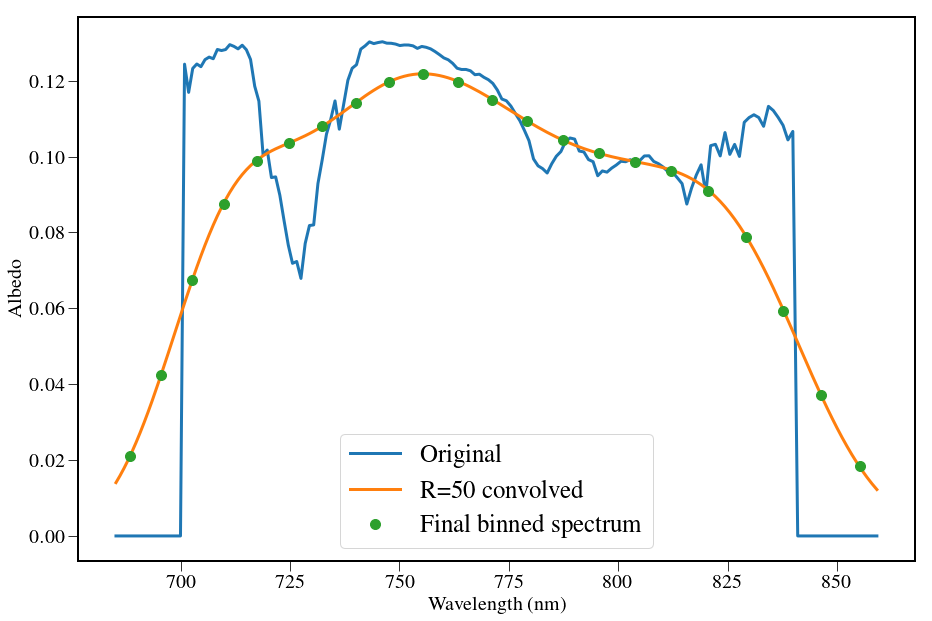

In [51]:
lams = spectrum[:, 0] * 1000.
spec = spectrum[:, 1]
dlam = (lams[1]-lams[0])
print dlam
# minlam = 600
# maxlam = 720
minlam = 700
maxlam = 840
spec[np.logical_or(lams<minlam,lams>maxlam)]=0.
minlam = 685
maxlam = 860
midlam = 0.5*(maxlam+minlam)
R = 50
Dlam = midlam/R
FWHM = Dlam/dlam
nbins = int(round((maxlam-minlam)/Dlam))
print "Number of bins:", nbins
Dlam = (maxlam-minlam)/nbins
FWHM = Dlam/dlam
print FWHM
convolved = ndimage.filters.gaussian_filter1d(
    spec, FWHM/2.35, order=0, mode='nearest')


cropped_conv = convolved[lams > minlam]
cropped_spec = spec[lams > minlam]
lams = lams[lams > minlam]
cropped_conv = cropped_conv[lams < maxlam]
cropped_spec = cropped_spec[lams < maxlam]
lams = lams[lams < maxlam]

cropped_conv2 = cropped_conv.reshape((len(cropped_conv), 1))
binned = np.reshape(
    frebin(cropped_conv2, (1, 2*nbins), total=False), -1)
wl = lams.reshape((len(lams), 1))
w = np.reshape(frebin(wl, (1, 2*nbins), total=False), -1)
plt.figure(figsize=(15, 10))
plt.plot(lams, cropped_spec, label='Original', lw=3)
plt.plot(lams, cropped_conv, label='R=50 convolved', lw=3)
plt.plot(w, binned, 'o', markersize=10,label='Final binned spectrum')
plt.legend(fontsize=25)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Albedo')


## Simple shift of spectrum due to error in wavecal

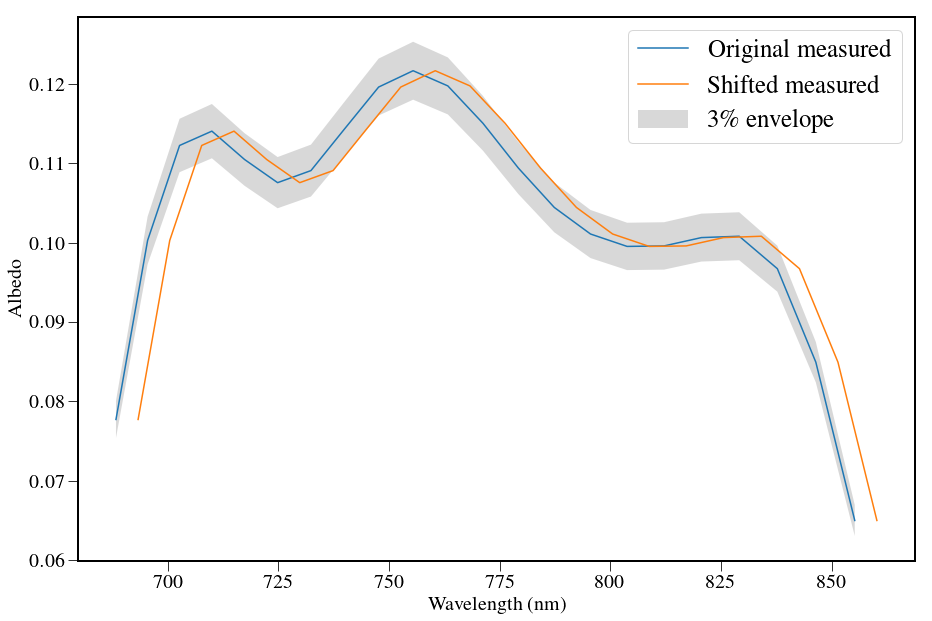

In [24]:
plt.figure(figsize=(15, 10))
plt.plot(w, binned, markersize=10, label='Original measured')
plt.plot(w+5, binned, markersize=10, label='Shifted measured')
plt.fill_between(w, binned*0.97, binned*1.03, alpha=0.3,
                 facecolor='gray', label='3\% envelope')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Albedo')
plt.legend(fontsize=25)

## Now suppose we have an error in wavelength calibration

Text(0,0.5,u'Albedo')

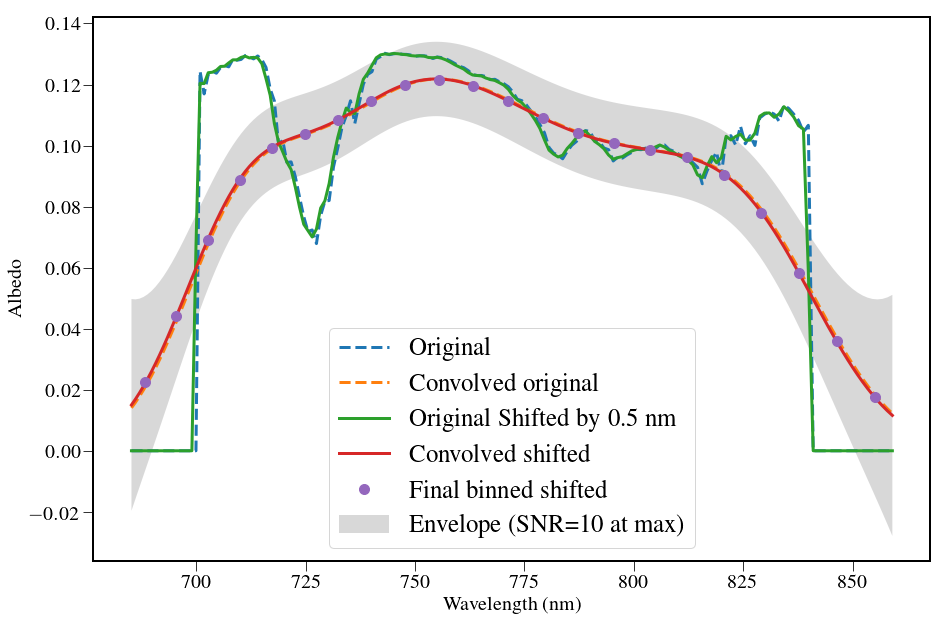

In [52]:
plt.figure(figsize=(15, 10))
plt.plot(lams, cropped_spec, label='Original', lw=3, linestyle='dashed')
plt.plot(lams, cropped_conv, label='Convolved original',
         lw=3, linestyle='dashed')

dlambda = .5  # in nm
# reload from scratch
lams = spectrum[:, 0] * 1000.
spec = spectrum[:, 1]
spec_func = interp1d(lams, spec, fill_value='extrapolate')
newspec = spec_func(lams+dlambda)
convolved = ndimage.filters.gaussian_filter1d(
    newspec, FWHM/2.35, order=0, mode='nearest')

cropped_conv = convolved[lams > minlam]
cropped_spec = newspec[lams > minlam]
lams = lams[lams > minlam]
cropped_conv = cropped_conv[lams < maxlam]
cropped_spec = cropped_spec[lams < maxlam]
lams = lams[lams < maxlam]

cropped_conv2 = cropped_conv.reshape((len(cropped_conv), 1))
binned_shifted = np.reshape(
    frebin(cropped_conv2, (1, 2*nbins), total=False), -1)
wl = lams.reshape((len(lams), 1))
w = np.reshape(frebin(wl, (1, 2*nbins), total=False), -1)

plt.plot(lams, cropped_spec, lw=3,
         label='Original Shifted by {:} nm'.format(dlambda))
plt.plot(lams, cropped_conv, label='Convolved shifted', lw=3)
plt.plot(w, binned_shifted, 'o', markersize=10, label='Final binned shifted')
plt.fill_between(lams, cropped_conv-0.1*np.amax(cropped_conv)*np.sqrt(np.amax(cropped_conv)/cropped_conv), cropped_conv+0.1*np.amax(cropped_conv)*np.sqrt(np.amax(cropped_conv)/cropped_conv), alpha=0.3,
                 facecolor='gray', label='Envelope (SNR=10 at max)')

plt.legend(fontsize=25)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Albedo')


## Equivalent albedo difference

Text(0.5,1,u'Equivalent albedo difference for a 0.5 nm wavelength error')

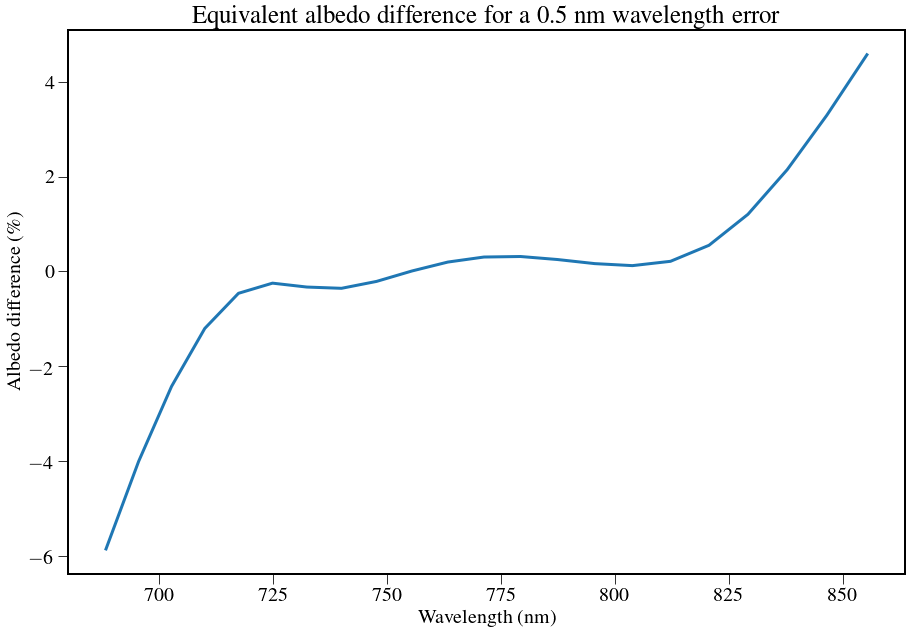

In [53]:
plt.figure(figsize=(15, 10))
plt.plot(w, (binned-binned_shifted)/binned*100, lw=3)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Albedo difference (\%)')
plt.title('Equivalent albedo difference for a {:} nm wavelength error'.format(
    dlambda), fontsize=25)

In [7]:
print w

[ 703.99386131  711.13933577  718.37818248  725.69781752  733.06343796
  740.54678102  748.07058394  755.67791241  763.38474453  771.1329635
  778.99781022  786.91981022  794.91416788  803.02929197  811.17971533
  819.445       827.78629197  836.188     ]


## Quick compare of rebinning functions

In [8]:
import skimage.transform

wl = lams.reshape((len(lams), 1))
print wl.shape
w = np.reshape(frebin(wl, (1, 2*nbins), total=False), -1)
s = float(2.*nbins)/float(len(lams))
print s
interp = np.reshape(skimage.transform.rescale(
    wl, scale=(s, 1), order=3, cval=0), -1)
print interp, len(interp), w-interp
# print wl[1:]-wl[:-1]

(137, 1)
0.131386861314
[ 703.97612578  711.14017998  718.37743786  725.68800286  733.07228906
  740.53253743  748.06836226  755.68105758  763.37147724  771.13955304
  778.9874945   786.91506946  794.92286113  803.01208594  811.18407078
  819.43899714  827.77776013  836.20211613] 18 [ 0.01773553 -0.00084421  0.00074462  0.00981466 -0.00885111  0.01424359
  0.00222168 -0.00314517  0.01326729 -0.00658953  0.01031572  0.00474076
 -0.00869325  0.01720603 -0.00435546  0.00600286  0.00853184 -0.01411613]


# Fit polynomial coefficients

In [121]:
xlistarr = fits.getdata(par.wavecalDir+'xlistarr.fits')
ylistarr = fits.getdata(par.wavecalDir+'ylistarr.fits')


In [123]:
xindx = np.arange(-par.nlens / 2, par.nlens / 2 + 1)
xindx, yindx = np.meshgrid(xindx, xindx)

missing = np.isnan(ylistarr[0])

In [122]:
print np.isnan(xlistarr[0])

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


In [135]:
missing = np.isnan(xlistarr[0])
X = np.reshape(xindx[~missing],-1)
Y = np.reshape(yindx[~missing],-1)
A = np.array([np.ones_like(X), X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
B = np.reshape(xlistarr[0][~missing],-1)
print A.shape,B.shape
coeffx, r, rank, s = np.linalg.lstsq(A, B)
xcoords = np.zeros_like(ylistarr[0])
xcoords[missing] = np.NaN
xcoords[~missing] = np.reshape(np.dot(A,coeffx),xlistarr[0][~missing].shape)




missing = np.isnan(ylistarr[0])
X = np.reshape(xindx[~missing],-1)
Y = np.reshape(yindx[~missing],-1)
A = np.array([np.ones_like(X), X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
B = np.reshape(ylistarr[0][~missing],-1)
print A.shape,B.shape
coeffy, r, rank, s = np.linalg.lstsq(A, B)
ycoords = np.zeros_like(ylistarr[0])
ycoords[missing] = np.NaN
ycoords[~missing] = np.reshape(np.dot(A,coeffy),ylistarr[0][~missing].shape)


(5916, 9) (5916,)
(5916, 9) (5916,)


In [116]:
print coeff

[  5.15045220e+02  -5.98595680e+00   1.19712413e+01  -3.66141328e-07
  -4.64156895e-07  -1.59319320e-08  -1.11507819e-05   9.28873063e-07
   1.62772355e-05]


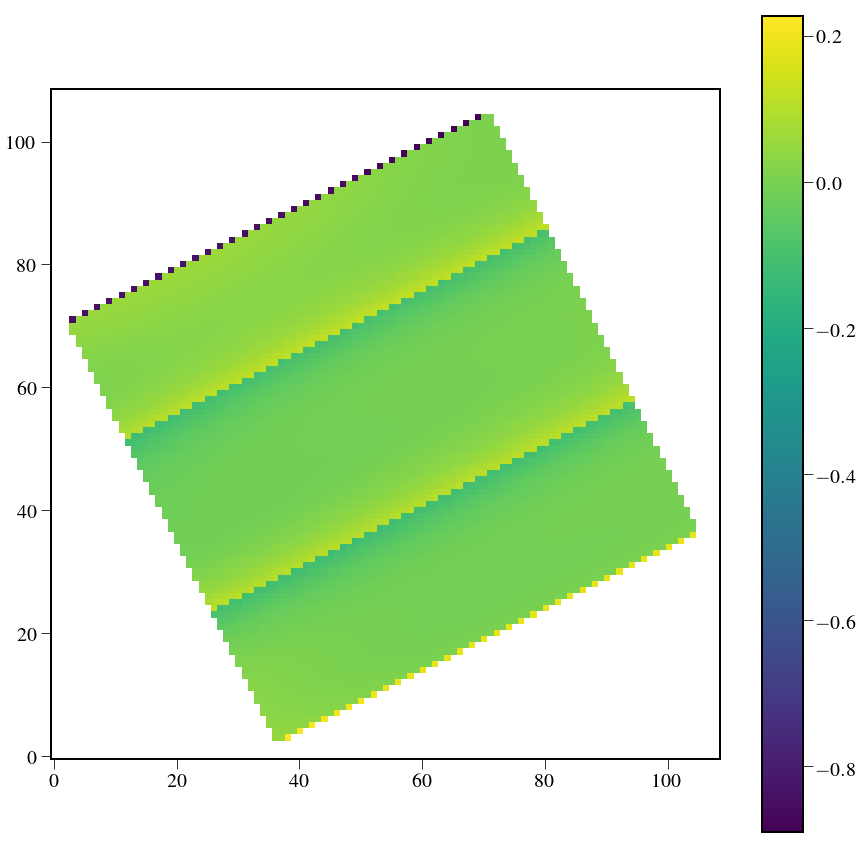

In [137]:
plt.figure(figsize=(15,15))
plt.imshow(xlistarr[0]-xcoords)
plt.colorbar()

In [129]:
dat = fits.getdata(par.wavecalDir+'det_600.fits')

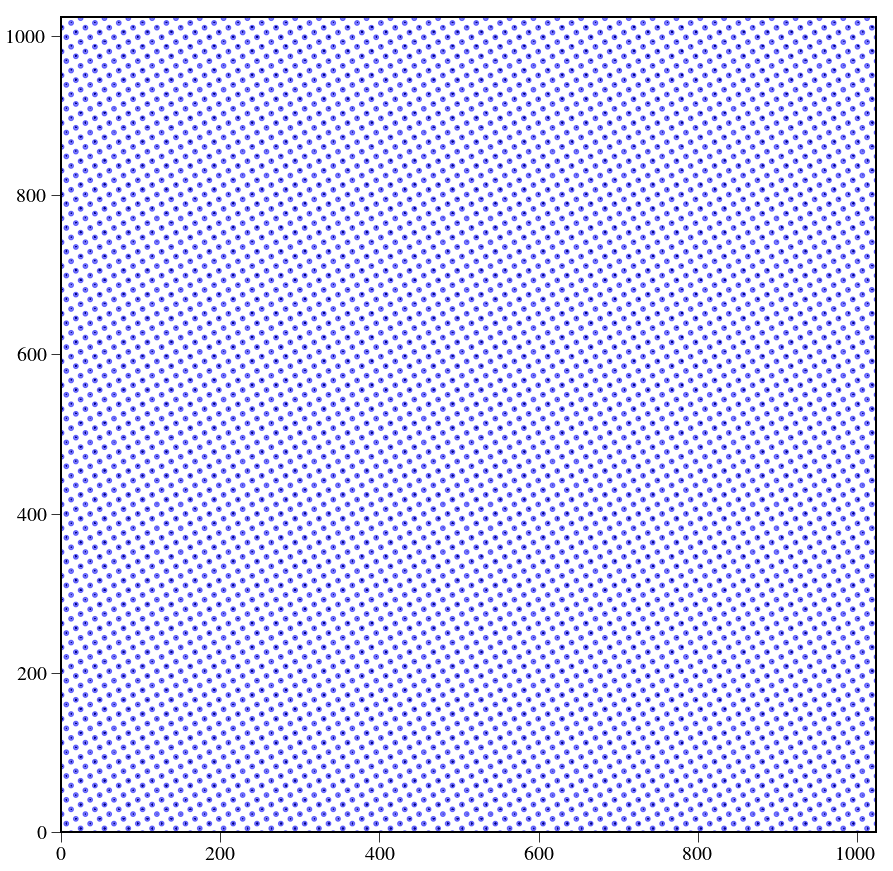

In [140]:
import matplotlib as mpl
def do_inspection(par, image, xpos, ypos, lam):

    xg, yg = xpos.shape
    vals = np.array([(xpos[m, n], ypos[m, n])
                     for m in range(xg) for n in range(yg)])
    pos = (vals[:, 0], vals[:, 1])
    fig, ax = plt.subplots(figsize=(15, 15))
    mean = np.mean(image)
    std = np.std(image)
    norm = mpl.colors.Normalize(vmin=mean, vmax=mean + 5 * std)
    ax.imshow(
        image,
        cmap='Greys',
        norm=norm,
        interpolation='nearest',
        origin='lower')
    for val in vals:
        circle = plt.Circle(val, 3, color='blue', lw=1, alpha=0.5)
        ax.add_artist(circle)
    fig.savefig('/Users/mrizzo/Downloads/test_%3d.png' % (lam), dpi=300)

# do_inspection(par,dat,xlistarr[0],ylistarr[0],600)
do_inspection(par,dat,xcoords,ycoords,601)